The other day I was working on a project involving Gaussian puff models and I noticed that I had made a significant mistake, a mistake I have made several times without noticing, and one that invalidated [a whole bunch of work I that I had done previously](/posts/integrated_puff/), so I thought this would be a good opportunity to examine my mistake and it's consequences.

## The Gaussian puff model

To re-cap on what a Gaussian puff model even is: for a short duration release (strictly an instantaneous release) of a neutrally buoyant substance at ground-level, the concentration can be modeled as the product of three Gaussian distributions:

$$ c \left(x,y,z,t \right) = \dot{m} \Delta t \cdot g_x(x, t) \cdot g_y(y) \cdot g_z(z) $$

where

$$ g_x(x,t) = {1 \over \sqrt{2\pi} \sigma_x } \exp \left( -\frac{1}{2} \left( x-u t \over \sigma_x \right)^2 \right) $$

$$ g_y(y) = {1 \over \sqrt{2\pi} \sigma_y } \exp \left( -\frac{1}{2} \left( y \over \sigma_y \right)^2 \right) $$

$$ g_z(z) = {2 \over \sqrt{2\pi} \sigma_z } \exp \left( -\frac{1}{2} \left( z \over \sigma_z \right)^2 \right) $$

Where $\dot{m}$ is the mass emission rate, *&Delta;t* the duration of the release, and *u* the ambient windspeed. The coordinates are such that the release point is at the origin, the puff moves in the downwind, *x*, direction while spreading into the crosswind, *y*, and vertical, *z*, directions.

The dispersion parameters, *&sigma;<sub>x</sub>*, *&sigma;<sub>y</sub>*, *&sigma;<sub>z</sub>* are all functions of the downwind distance and the atmospheric stability.

In [1]:
#| output: false
# class F puff dispersion
# x is in meters
σx(x) = 0.024*x^0.89
σy(x) = σx(x)
σz(x) = 0.05*x^0.61

σz (generic function with 1 method)

## Integrating the puff

What this generates is an instantaneous release of all of the mass in an infinitesimal point that grows as it moves downwind. This isn't terribly realistic for releases of any appreciable duration (all of the mass is released instantly in this model), so a common approach is to break up the release into a sequence of *n* smaller puffs that each capture the mass released over the sub-interval ${ \Delta t \over n }$. Taking the limit as $n \to \infty$ equates to integrating the puff model from *t - &Delta;t* to *t* giving a nice solution in terms of the error function *erf* and ... this is where I made the critical mistake.

The dispersion parameters are functions of the downwind distance, but critically..*to what?* Taken as the downwind distance to the point being calculated, the dispersion parameters are constants (with respect to time) and the problem simplifies to integrating the Gaussian $g_{x}(x,t)$ with respect to *t*, which is what I had assumed. *However* if the dispersion parameters are actually correlated to the downwind distance of the *cloud center*, which is $x_c = u t$, they are in fact functions of time and this does not work.

This distinction is by no means made obvious in many of the references for chemical hazard analysis. Most are either vague about it or take the dispersion parameters at the downwind distance *of the point being calculated*. My main reference is the CCPS *Guidelines for Consequence Analysis of Chemical Releases* and it does this.[@ccps-1999 pages 107-108] As do several workbooks I have seen. However Lees[@lees-1996] notes that the dispersion parameters for the Pasquill-Gifford puff model (which this is) are given by[@lees-1996 page 15/112]

$$ \sigma = { C^2 \over 2 } \left( u t \right)^{2-n} $$

where *C* and *n* are some constants from Sutton, and in general the dispersion correlations are functions of travel time with a lot of discussion in the literature of *to what power*. The standard correlations for the dispersion parameters come from Slade[@slade-1968 pages 117-189] which gives some details on how the measurements were actually taken. It certainly seems to me that the downwind distance was to the cloud center, i.e. the experimenters measured the cloud dimensions at the downwind point to which it had traveled. Which makes the travel time and windspeed implicit.

I think it is a reasonable confusion as the dispersion parameters for a continuous release, a Gaussian *plume* model, are indeed functions of the downwind distance to the point being calculated. It is also frequently the case that examples are given for the concentration at the cloud center, in which case the downwind distance at the point being calculated *is* the downwind distance to the cloud center.

## Dispersion nearly-constants

How critical of a mistake is this? For regions far enough from the origin the dispersion parameters do not vary much in the neighborhood of the plume center. This is shown in the plot below where the difference is taken over the interval $[ x - \sigma_x, x + \sigma_x ]$. At distances further than a few hundred meters the difference is only a few percent. Suggesting that it might not be an unreasonable approximation to assume the dispersion parameters are constants for the purpose of the integral.

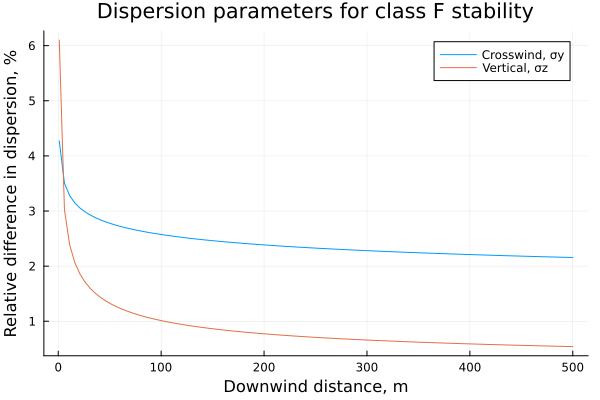

In [2]:
#| echo: false
#| label: fig-disp-consts
#| fig-cap: "The relative change in dispersion parameters, &plusmn;1&sigma;, as a function of downwind distance."

using Plots

function disp_error(x, σ)
    σ_mid = σ(abs(x))
    σ_low = σ(abs(x-σ_mid))
    σ_hi  = σ(abs(x+σ_mid))
    return abs(σ_hi - σ_low)/σ_mid
end

let

xs = range(1,500,length=100)
y_err = [ disp_error(x, σy) for x in xs ] .* 100
z_err = [ disp_error(x, σz) for x in xs ] .* 100

plot(xs, y_err, lab="Crosswind, σy")
plot!(xs, z_err, lab="Vertical, σz")
plot!( palette=:seaborn_bright, title="Dispersion parameters for class F stability",
    xlabel="Downwind distance, m", ylabel="Relative difference in dispersion, %")

end

## Different approaches to approximation

Another way of approaching this is simply to view it as an *approximation* instead of an error. On the one hand this is a pretty great rhetorical trick: my answer isn't wrong, it's just *differently true*. But it could be the case that this is a useful simplification, just by eye-balling isopleths and looking at limiting behavior [in the previous notebook](/posts/integrated_puff/) it certainly looked reasonable.

To make life easier, going forward, I am going to define a unit-less time
$$ t = { u t^{\prime} \over L } $$

and unit-less distances

$$ x = {x^{\prime} \over L } \\ y = {y^{\prime} \over L } \\ z = {z^{\prime} \over L } $$

where I am abusing notation with the $\prime$ indicates the variable with units, and no $\prime$ indicates it is unitless. A characteristic length, $L$, is introduced to make everything unitless and, due to the dispersion correlations $L = 1 \mathrm{m}$ is the most convenient.

We can then explore the performance of different approximations to the integrated puff model by only examining the Gaussian distributions -- with no dependence upon $\dot{m}$ or *u*.

In [3]:
#| output: false
g(ξ,σ) = exp(-0.5*(ξ/σ)^2)/(√(2π)*σ)

gx(x, t) = g((x-t),σx(t))
gy(y, t) = g(y,σy(t))
gz(z, t) = 2*g(z,σz(t))

pf(x,y,z,t; Δt) = gx(x,t)*gy(y,t)*gz(z,t)*Δt

pf (generic function with 1 method)

### Sum of discrete puffs

The first type of approximation is to divide the release interval into *n* sub-intervals and *n* Gaussian puffs

In [4]:
#| output: false
function Σpf(x,y,z,t; Δt, n)
    Δt = min(t,Δt)
    δt = Δt/(n-1)
    _sum = 0
    for i in 0:(n-1)
        t′ = t-i*δt
        pf_i = t′>0 ? gx(x,t′)*gy(y,t′)*gz(z,t′)*δt : 0
        _sum += pf_i
    end
    return _sum
end

Σpf (generic function with 1 method)

### Integrating assuming constant &sigma;s

The next type of approximation is the one I made in [the previous post](/posts/integrated_puff/#integrated-puffs) wherein $g_x(x,t)$ is integrated with respect to time, treating the &sigma;s as constants.

There is a little sleight of hand as I include the downwind distance dependence of the &sigma;s after the integration (they aren't *actually* constants)

In [5]:
#| output: false
using SpecialFunctions: erf

function ∫gx(x,t,Δt)
    Δt = min(t,Δt)
    a  = (x-(t-Δt))/(√2*σx(t-Δt))
    b  = (x-t)/(√2*σx(t))
    return erf(b,a)/2
end

∫pf_approx(x,y,z,t; Δt) = ∫gx(x,t,Δt)*gy(y,x)*gz(z,x)

∫pf_approx (generic function with 1 method)

### Numerically integrating the full model

Finally, I take advantage of the `QuadGK` package to numerically integrate the Gaussian puff model, including the time dependence of the dispersion parameters.

In [6]:
#| output: false
using QuadGK: quadgk

function ∫pf(x,y,z,t; Δt)
    Δt = min(t,Δt)
    integral, err = quadgk(τ -> gx(x,τ)*gy(y,τ)*gz(z,τ), t-Δt, t)
    return integral
end

∫pf (generic function with 1 method)

## Comparing performance

### Model error

To give a sense of how these successive approximations work, lets examine a series of slices through the cloud. The first is at a constant *x* on the center-line of the release, looking at how the concentration changes with time.

Just by eye-ball the the approximate integral is very close to the numerical exact(ish) integral, as is a large enough number of puffs. Importantly, I think, the approximate integral error is of the same order of magnitude as a large number of puffs -- so this is *at least as good* in a sense as the discrete sum of puffs method, given that we can vary the number of puffs to always make it a better/worse approximation

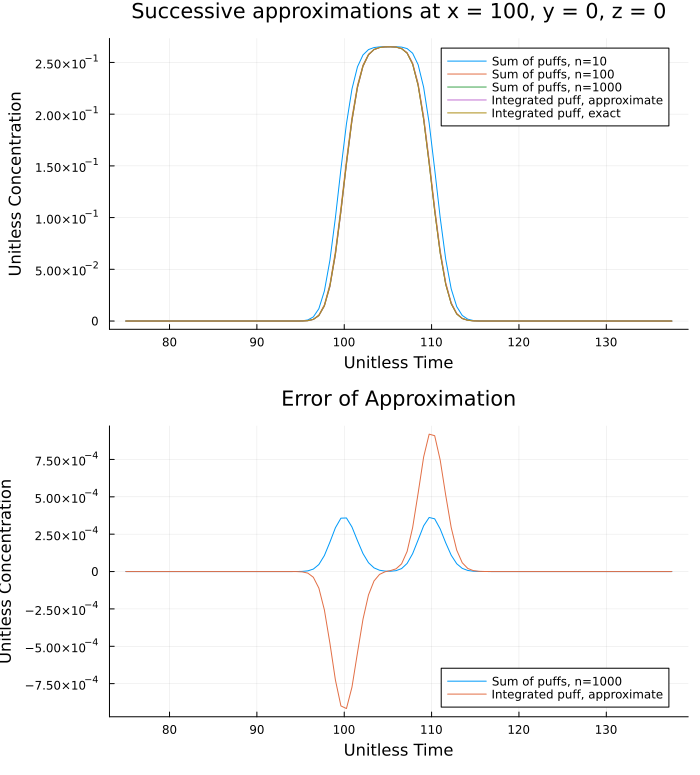

In [18]:
#| echo: false
#| label: fig-time-error
#| fig-cap: "Top: concentration profile over time, at a fixed location, for discrete sums of puffs, the approximated integral, and the exact integral. Bottom: the relative error of a sum of discrete puffs and the approximate integral."

let x₁=100, Δt=10
    # point of interest
    y₁ = 0
    z₁ = 0
    t₁ = x₁

    ts = range(0.75*t₁,1.25*(t₁+Δt); length=100)

    exact   = [ ∫pf(x₁,y₁,z₁,t′; Δt=Δt) for t′ in ts ];
    approx  = [ ∫pf_approx(x₁,y₁,z₁,t′; Δt=Δt) for t′ in ts ];
    sp_10   = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=10) for t′ in ts ];
    sp_100  = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=100) for t′ in ts ];
    sp_1000 = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=1000) for t′ in ts ];

    p1, p2 = plot(), plot()

    # plot 1, the actual performance
    plot!(p1, ts, sp_10, lab="Sum of puffs, n=10")
    plot!(p1, ts, sp_100, lab="Sum of puffs, n=100")
    plot!(p1, ts, sp_1000, lab="Sum of puffs, n=1000")
    plot!(p1, ts, approx, lab="Integrated puff, approximate")
    plot!(p1, ts, exact, lab="Integrated puff, exact")
    plot!(p1, palette=:seaborn_bright, legend=:topright,
        xformatter=:plain, xlabel="Unitless Time", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Successive approximations at x = $x₁, y = $y₁, z = $z₁")

    # plot 2, relative difference
    plot!(p2, ts, sp_1000 .- exact, lab="Sum of puffs, n=1000")
    plot!(p2, ts, approx .- exact, lab="Integrated puff, approximate")
    plot!(p2, palette=:seaborn_bright, legend=:bottomright,
        xformatter=:plain, xlabel="Unitless Time", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Error of Approximation")

    plot(p1, p2, size=(700,775), layout = @layout [°;°])

end

In the crosswind and vertical directions the sum of discrete puffs approximation works decidedly less well, at least at this slice in the cloud, while the approximate integral still works relatively well. I would say it is still *at least as good* as a sum of discrete puffs for a suitably large number of puffs.

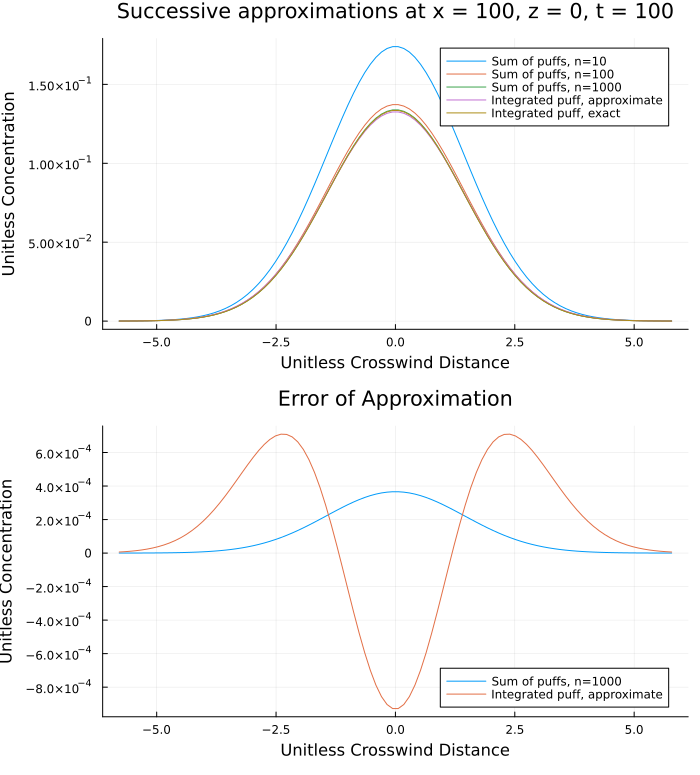

In [9]:
#| echo: false
#| label: fig-crosswind-error
#| fig-cap: "Top: crosswind concentration profile, at a fixed location and time, for discrete sums of puffs, the approximated integral, and the exact integral. Bottom: the relative error of a sum of discrete puffs and the approximate integral."

let x₁=100, Δt=10
    t₁ = x₁
    z₁ = 0
    ys = range(-4σy(x₁),4σy(x₁); length=100)

    exact   = [ ∫pf(x₁,y,z₁,t₁; Δt=Δt) for y in ys ];
    approx  = [ ∫pf_approx(x₁,y,z₁,t₁; Δt=Δt) for y in ys ];
    sp_10   = [ Σpf(x₁,y,z₁,t₁; Δt=Δt, n=10) for y in ys ];
    sp_100  = [ Σpf(x₁,y,z₁,t₁; Δt=Δt, n=100) for y in ys ];
    sp_1000 = [ Σpf(x₁,y,z₁,t₁; Δt=Δt, n=1000) for y in ys ];

    p1, p2 = plot(), plot()

    # plot 1, the actual performance
    plot!(p1, ys, sp_10, lab="Sum of puffs, n=10")
    plot!(p1, ys, sp_100, lab="Sum of puffs, n=100")
    plot!(p1, ys, sp_1000, lab="Sum of puffs, n=1000")
    plot!(p1, ys, approx, lab="Integrated puff, approximate")
    plot!(p1, ys, exact, lab="Integrated puff, exact")
    plot!(p1, palette=:seaborn_bright, legend=:topright,
        xformatter=:plain, xlabel="Unitless Crosswind Distance", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Successive approximations at x = $x₁, z = $z₁, t = $t₁")

    # plot 2, relative difference
    plot!(p2, ys, sp_1000 .- exact, lab="Sum of puffs, n=1000")
    plot!(p2, ys, approx .- exact, lab="Integrated puff, approximate")
    plot!(p2, palette=:seaborn_bright, legend=:bottomright,
        xformatter=:plain, xlabel="Unitless Crosswind Distance", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Error of Approximation")

    plot(p1, p2, size=(700,775), layout = @layout [°;°])
end

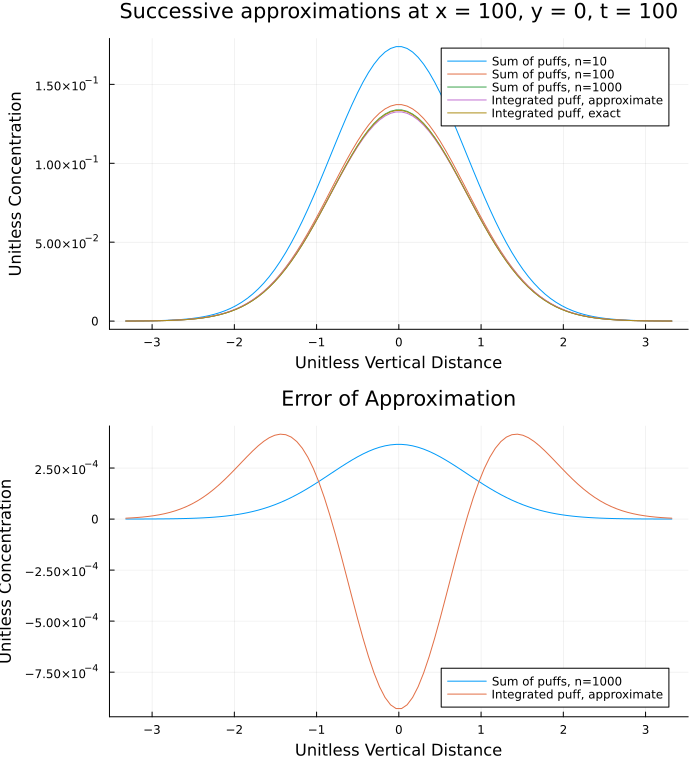

In [10]:
#| echo: false
#| label: fig-vertical-error
#| fig-cap: "Top: vertical concentration profile, at a fixed location and time, for discrete sums of puffs, the approximated integral, and the exact integral. Bottom: the relative error of a sum of discrete puffs and the approximate integral."

let x₁=100, Δt=10
    t₁ = x₁
    y₁ = 0
    zs = range(-4σz(x₁),4σz(x₁); length=100)

    exact   = [ ∫pf(x₁,y₁,z,t₁; Δt=Δt) for z in zs ];
    approx  = [ ∫pf_approx(x₁,y₁,z,t₁; Δt=Δt) for z in zs ];
    sp_10   = [ Σpf(x₁,y₁,z,t₁; Δt=Δt, n=10) for z in zs ];
    sp_100  = [ Σpf(x₁,y₁,z,t₁; Δt=Δt, n=100) for z in zs ];
    sp_1000 = [ Σpf(x₁,y₁,z,t₁; Δt=Δt, n=1000) for z in zs ];

    p1, p2 = plot(), plot()

    # plot 1, the actual performance
    plot!(p1, zs, sp_10, lab="Sum of puffs, n=10")
    plot!(p1, zs, sp_100, lab="Sum of puffs, n=100")
    plot!(p1, zs, sp_1000, lab="Sum of puffs, n=1000")
    plot!(p1, zs, approx, lab="Integrated puff, approximate")
    plot!(p1, zs, exact, lab="Integrated puff, exact")
    plot!(p1, palette=:seaborn_bright, legend=:topright,
        xformatter=:plain, xlabel="Unitless Vertical Distance", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Successive approximations at x = $x₁, y = $y₁, t = $t₁")

    # plot 2, relative difference
    plot!(p2, zs, sp_1000 .- exact, lab="Sum of puffs, n=1000")
    plot!(p2, zs, approx .- exact, lab="Integrated puff, approximate")
    plot!(p2, palette=:seaborn_bright, legend=:bottomright,
        xformatter=:plain, xlabel="Unitless Vertical Distance", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Error of Approximation")

    plot(p1, p2, size=(700,775), layout = @layout [°;°])
end

This is, of course, very particular to that point downwind of the release. As we move closer to the origin the integral approximation gets worse, but then so does the sum of discrete puffs model. Especially for a low number of puffs: they become visibly discrete. I think this reinforces that, at least for class F stability, this approximation is in the same ball park as summing over a set discrete Gaussian puffs.

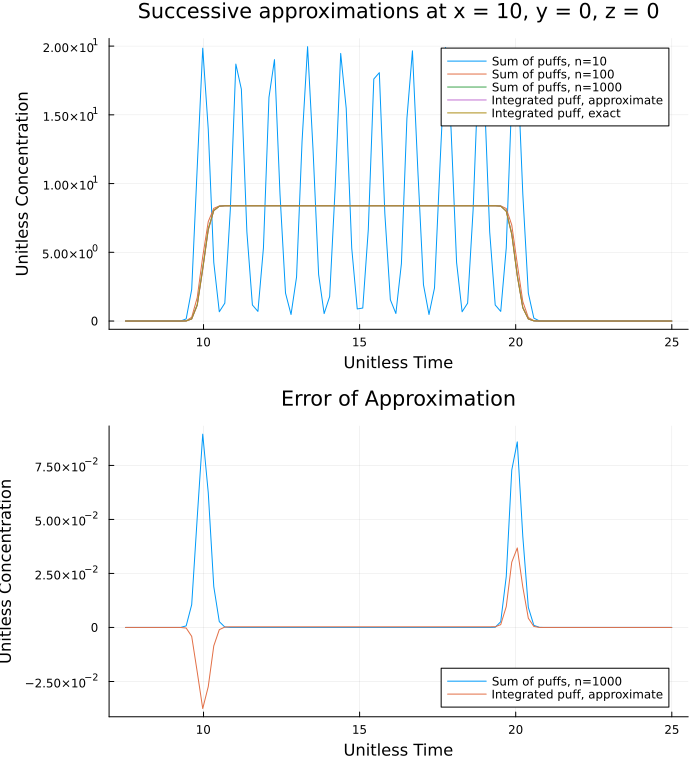

In [20]:
#| echo: false
#| label: fig-near-origin
#| fig-cap: "Top: concentration profile over time near the origin, for discrete sums of puffs, the approximated integral, and the exact integral. Bottom: the relative error of a sum of discrete puffs and the approximate integral."

let x₁=10, Δt=10
    # point of interest
    y₁ = 0
    z₁ = 0
    t₁ = x₁

    ts = range(0.75*t₁,1.25*(t₁+Δt); length=100)

    exact   = [ ∫pf(x₁,y₁,z₁,t′; Δt=Δt) for t′ in ts ];
    approx  = [ ∫pf_approx(x₁,y₁,z₁,t′; Δt=Δt) for t′ in ts ];
    sp_10   = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=10) for t′ in ts ];
    sp_100  = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=100) for t′ in ts ];
    sp_1000 = [ Σpf(x₁,y₁,z₁,t′; Δt=Δt, n=1000) for t′ in ts ];

    p1, p2 = plot(), plot()

    # plot 1, the actual performance
    plot!(p1, ts, sp_10, lab="Sum of puffs, n=10")
    plot!(p1, ts, sp_100, lab="Sum of puffs, n=100")
    plot!(p1, ts, sp_1000, lab="Sum of puffs, n=1000")
    plot!(p1, ts, approx, lab="Integrated puff, approximate")
    plot!(p1, ts, exact, lab="Integrated puff, exact")
    plot!(p1, palette=:seaborn_bright, legend=:topright,
        xformatter=:plain, xlabel="Unitless Time", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Successive approximations at x = $x₁, y = $y₁, z = $z₁")

    # plot 2, relative difference
    plot!(p2, ts, sp_1000 .- exact, lab="Sum of puffs, n=1000")
    plot!(p2, ts, approx .- exact, lab="Integrated puff, approximate")
    plot!(p2, palette=:seaborn_bright, legend=:bottomright,
        xformatter=:plain, xlabel="Unitless Time", 
        yformatter=:scientific, ylabel="Unitless Concentration",
        title="Error of Approximation")

    plot(p1, p2, size=(700,775), layout = @layout [°;°])

end

### Compute time

Model error is not the only factor in deciding upon an approximation. Since `QuadGK` exists we have to ask ourselves, why would we not always use it? We can answer that by benchmarking the three approaches at a particular point of interest (I don't think the choice of point impacts the calculations at all)

In [12]:
#| output: false
using BenchmarkTools: @benchmark

# point of interest
x₁ = 100
y₁ = σy(x₁)
z₁ = σz(x₁)
t₁ = x₁

100

Starting with the full numerical integration of the model, this is the *time to beat*. Any approximation that takes longer than ~30&mu;s is literally pointless: it generates worse results and takes longer.

In [13]:
@benchmark ∫pf(x₁,y₁,z₁,t₁; Δt=10)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  28.056 μs … 57.603 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     28.200 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   28.570 μs ±  1.565 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▁  ▃▃   ▁▂▁▁                                              ▁
  ███▇▅██▇▅▄█████▆▆▆▇▆█▇▆▄▃▁▄▄▄▃▆▅▄▄▃▁▃▁▃▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▄▅▆▇▆ █
  28.1 μs      Histogram: log(frequency) by time      37.7 μs <

 Memory estimate: 384 bytes, allocs estimate: 3.

As we expect, the sequence of discrete puffs is much faster for fewer puffs, and adding an order of magnitude more puffs increases the time by an order of magnitude. At around *n=100* we are no longer gaining anything over the full numerical integration. So, if the near-field matters a lot to you, then this is probably not a great approximation as the number of puffs required to approximate the full numerical integration well takes longer than just doing the integration.

In [14]:
@benchmark Σpf(x₁,y₁,z₁,t₁; Δt=10, n=10)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.746 μs …  11.498 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.768 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.920 μs ± 450.991 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  ▅  ▅▂▁▁▂                                                 ▁
  ██▄█▇▅██████▇▆▄▄▄▃▅▄▄▂▄▄▅▃▄▅▅▆▇▇▆▆▇▇▆▆▅▅▅▅▆▅▅▅▅▄▃▅▅▄▅▅▄▄▄▂▃ █
  3.75 μs      Histogram: log(frequency) by time      5.97 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [15]:
@benchmark Σpf(x₁,y₁,z₁,t₁; Δt=10, n=100)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  37.090 μs … 77.023 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     37.199 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   37.760 μs ±  2.411 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █    ▂▁    ▃                                                ▁
  █▇▁▁▁██▃▃▁▃█▇▇▆▄▄▇█▅▄▄▄▄▄▄▃▄▄▃▁▅▁▄▃▁▁▃▃▃▃▄▇▇█▇▇▆▄▅▅▅▆▄▄▆▄▄▄ █
  37.1 μs      Histogram: log(frequency) by time      49.3 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

Finally we have the integral approximation. This takes ~1/50th the time as the full numerical integration and, by the results above, it potentially performs just as well as the discrete puff approximation. In the examples above it was doing as well as discrete puff approximations that are too large to be worthwhile.

In [16]:
@benchmark ∫pf_approx(x₁,y₁,z₁,t₁; Δt=10)

BenchmarkTools.Trial: 10000 samples with 189 evaluations.
 Range (min … max):  534.974 ns … 988.852 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     547.606 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   560.844 ns ±  40.302 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇▃▅█▅▅ ▅▃▄ ▃▄▁▁▁▁▁                                            ▂
  ██████▇█████████████▇█▇▇▆▆▆▆▅▇▇▆▅▆▇▆▆▅▅▅▅▄▄▆▅▅▅▆▆▄▅▅▂▅▄▅▄▃▅▅▅ █
  535 ns        Histogram: log(frequency) by time        770 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

I also have put no effort into optimizing any of this code, so take this with a grain of salt. Like the examination of the model error this is hardly rigorous, it is more suggestive than anything. It is possible that one could dramatically improve the discrete puff model, or re-write how the models are calculated to be more performant than I have. I prefer to write code that is easy for me to read, and re-uses things, but that does not necessarily translate into fast.

## Conclusions

I think it's worth noting that calculations that take on the order of tens of microseconds, on my crappy old laptop, are *fast*. To make the various plots required calculating the concentration at hundreds of points and my laptop did it all in the blink of an eye. I would say the first choice, all things being equal, would be simply to use the `QuadGK` model and call it a day. In terms of lines of code it is certainly short, all the heavy lifting is being done by the library. It also best captures *what you are trying to achieve*.

If you are doing a huge number of calculations, and can tolerate some model error, then the integral approximation is a good choice. It is the fastest and can perform as well as the discrete puff model. That said, there is an elephant in the room: The two integral approaches strictly require that all of the puffs are moving along the same line, at the same speed. For a great many chemical release scenarios that is entirely the set of assumptions being made, so it works great. However, for more complex atmospheric conditions -- with variable windspeed and direction -- then they don't work at all. Or, at least, it is not obvious to me how to adapt them to work. A slightly tweaked discrete puff model, tracking each puff's individual center location and windspeed, would be quite easy to implement, giving a more *flexible* model overall. This is in fact the how several more complicated atmospheric dispersion modeling tools work.


## References
::: {#refs}
:::